In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import azureml.core
from azureml.core import Workspace
 
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
import matplotlib.pyplot as plt

np.random.seed(1)
# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.27.0


In [2]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, sep='\t')

ml-models	eastus	firstresource


In [4]:
experiment_name = 'Model'

from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

In [5]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# choose a name for your cluster
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "cpu-cluster")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)

# This example uses CPU VM. For using GPU VM, set SKU to STANDARD_NC6
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")


if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print("found compute target: " + compute_name)
else:
    print("creating new compute target...")
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size,
                                                                min_nodes = compute_min_nodes, 
                                                                max_nodes = compute_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)
    
    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    
     # For a more detailed view of current AmlCompute status, use get_status()
    print(compute_target.get_status().serialize())

found compute target: cpu-cluster


In [6]:
from azureml.core import Dataset
from azureml.opendatasets import MNIST

os.getenv('DefaultEndpointsProtocol=https;AccountName=firststorages;AccountKey=6G+i6e/EmAcFb/sbs6On47dyRO9E4m0fUWRVOe6qpv2cv0Ywfnc7dsXrPpziVDCsjeAearBqaFmhiPdIIyB/zg==;EndpointSuffix=core.windows.net')


blob_dset = Dataset.File.from_files('https://firststorages.blob.core.windows.net/cars')

# blob_dset


#to download the data set into your working directory
# data_folder = os.path.join(os.getcwd(), 'data')
# os.makedirs(data_folder, exist_ok=True)

# blob_dset = blob_dset.get_file_dataset()
# blob_dset.download(data_folder, overwrite=True)

#register the file data set into azure ml datasets
mnist_file_dataset =blob_dset.register(workspace=ws,
                                                 name='testing',
                                                 description='training and test dataset',
                                                 create_new_version=True)

In [7]:
# azureml-core of version 1.0.72 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = '2b0cab8f-c0cb-4530-b8a1-753f9a6c3035'
resource_group = 'FirstResource'
workspace_name = 'ml-models'

workspace = Workspace(subscription_id, resource_group, workspace_name)
img_width = 150
img_height = 150
batch_size = 32

#get the data from dataset
dataset = Dataset.get_by_name(workspace, name='testing')
# dataset.download(target_path='.', overwrite=True)



# divide your data into train and test using image data generator
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split
#train data set
train_generator = train_datagen.flow_from_directory(
    "cars",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training') # set as training data

#test data set
validation_generator =train_datagen.flow_from_directory(
    "cars", # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation') # set as testing data
# from PIL import Image
# data = []

# for i in train_generator:   
#     image=tf.keras.preprocessing.image.load_img(i, color_mode='RGB', 
#     target_size= (150,150))
#     image=np.array(image)
#     data.append(image)
    

Found 368 images belonging to 5 classes.
Found 91 images belonging to 5 classes.


In [8]:
classes = list(validation_generator.class_indices.keys())
classes

['2018-BMW-x7',
 'Ford-Explorer-2020',
 'Honda-Pilot-2008',
 'Lexus-ES-2019',
 'Toyoata-Camry-2009']

In [9]:
#Keras has an useful API which makes us easier to define the layers of our neural network
#define our Cnn model layers
model = keras.Sequential()
#model input shape
model.add(keras.Input(shape=(150, 150, 3)))


model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Dropout(rate=0.37))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Dropout(rate=0.37))

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Dropout(rate=0.37))

# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D((2, 2), strides=2))
# #model.add(layers.Dropout(rate=0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(5, activation= keras.activations.softmax ))

In [10]:
#specify optimizer and loss function for our model
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [11]:
#vview your model
# model.describe

# model.fit(train_generator,
# #          steps_per_epoch = 10,
#          epochs = 10,
#          validation_data = testing_generator
       
#          )


model.fit(
    train_generator,
#     steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    #validation_steps = validation_generator.samples // batch_size,
    epochs = 10)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 12 steps, validate for 3 steps
Epoch 1/10
12/12 [==============================] - 36s 3s/step - loss: 1.7008 - sparse_categorical_accuracy: 0.2011 - val_loss: 1.7067 - val_sparse_categorical_accuracy: 0.1978
Epoch 2/10
12/12 [==============================] - 32s 3s/step - loss: 1.7095 - sparse_categorical_accuracy: 0.1957 - val_loss: 1.7063 - val_sparse_categorical_accuracy: 0.1978
Epoch 3/10
12/12 [==============================] - 33s 3s/step - loss: 1.7095 - sparse_categorical_accuracy: 0.1957 - val_loss: 1.6920 - val_sparse_categorical_accuracy: 0.1978
Epoch 4/10
12/12 [==============================] - 32s 3s/step - loss: 1.7095 - sparse_categorical_accuracy: 0.1957 - val_loss: 1.7173 - val_sparse_categorical_accuracy: 0.1429
Epoch 5/10
12/12 [=========================

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        1

In [14]:
def predictImage(filename):
    img1 = image.load_img(filename,target_size=(150,150))

    
    plt.imshow(img1)
 
    Y = image.img_to_array(img1)
    
    X = np.expand_dims(Y,axis=0)
   
    val = model.predict(X)
    print(val)
    prediction = np.argmax(val, axis = 1)
    print(prediction)
    plt.xlabel(classes[prediction[0]])


[[0. 0. 1. 0. 0.]]
[2]


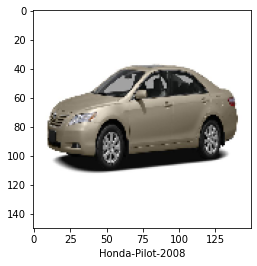

In [15]:
predictImage(r"cars/Toyoata-Camry-2009/10.jpg")

In [16]:

test = ImageDataGenerator(rescale=1/255)

                                
test_generator = test.flow_from_directory(
    "test",
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 50 images belonging to 5 classes.


In [18]:
test_generator.reset()
pred=model.predict(test_generator,verbose=1,steps=50/32)

2/1 [======================================] - 3s 1s/step


In [19]:
predicted_class_indices=np.argmax(pred,axis=1)

In [20]:
labels = (train_generator.class_indices)
labels = dict((x,y) for y,x in labels.items())
predictions = [labels[y] for y in predicted_class_indices]

In [21]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filenames":filenames,
                      "Predictions":predictions})

results

,Filenames,Predictions
0,Lexus-ES-2019/1.jpg,2018-BMW-x7
1,Lexus-ES-2019/10.jpg,2018-BMW-x7
2,Lexus-ES-2019/100.JPG,2018-BMW-x7
3,Lexus-ES-2019/11.jpg,2018-BMW-x7
4,Lexus-ES-2019/12.jpg,2018-BMW-x7
5,Lexus-ES-2019/13.jpg,2018-BMW-x7
6,Lexus-ES-2019/14.jpg,2018-BMW-x7
7,Lexus-ES-2019/15.jpg,2018-BMW-x7
8,Lexus-ES-2019/16.jpg,2018-BMW-x7
9,Lexus-ES-2019/17.jpg,2018-BMW-x7
